## Model 

This notebook contains the meat of our research. Everything up to this point has been about wrangling the data into a usable format, now we can begin actually learning from that data. 

1. **Data Preparation**
 - Load Data
 - Normalization
 - Reshaping
 - Data Augmentation
2. **CNN**
 - Define the Model
 - Set the optimizer and annealer
3. **Evaluate the Model**
 - Training and Evaluation Curves
 - Confusion Matrix

In [2]:
import pandas as pd
import numpy as np
import cv2

# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import matplotlib.image as mpimg
import seaborn as sns
import os

np.random.seed(2)

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

### Data Preparation

1. Load the Data

In [3]:
## DATA

patch_size = 64

folder_id = '38caa6a4'
base_dir = os.path.join('./data', folder_id)
test_dir = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')

test_patches = pd.read_csv(os.path.join(base_dir, 'test_patches.csv'))
train_patches = pd.read_csv(os.path.join(base_dir, 'train_patches.csv'))

def read_data(data, src_dir):
    
    size = len(data)
    images = np.zeros((size, patch_size, patch_size, 3), dtype=np.float32)
    labels = np.zeros(size, dtype=np.int64)
    
    for idx, row in data.iterrows():
        img = cv2.imread(os.path.join(src_dir, row['patch_name']))
        lab = row['label_id']
        images[idx] = img
        labels[idx] = lab
        
    return images, labels


train_images, train_labels = read_data(train_patches, train_dir)
test_images, test_labels = read_data(test_patches, test_dir)

display(np.unique(train_labels))
display(np.unique(test_labels))

array([1, 2, 3, 4])

array([1, 2, 3, 4])

In [4]:
# In order to use one-hot encoding we must shift all the labels by one so we have 0-3 instead of 1-4
train_labels -= 1
test_labels -= 1
train_labels_oh = to_categorical(train_labels)
test_labels_oh = to_categorical(test_labels)

train: 9766
test: 2915


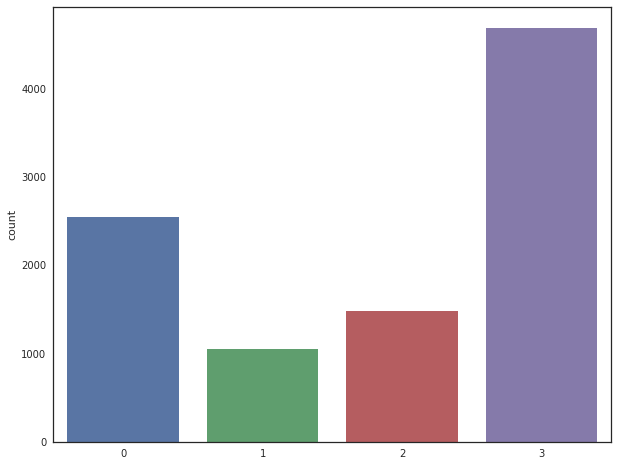

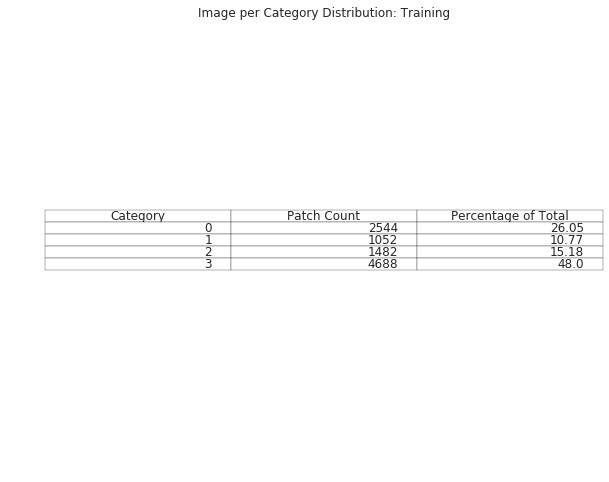

In [5]:
# Now let's inspect the results

print('train: {}'.format(len(train_images)))
print('test: {}'.format(len(test_images)))


# Let's view How the data is distributed
sns.countplot(train_labels)

def plot_patches_per_category_distribution(label_data, title=''):
    label_ids, label_counts = np.unique(label_data, return_counts=True)
    total_items = np.sum(label_counts)
    columns = ['Category', 'Patch Count', 'Percentage of Total']
    rows = label_ids
    cell_text = [
        [label_ids[0], label_counts[0], np.round((label_counts[0] / total_items)*100, 2) ],
        [label_ids[1], label_counts[1], np.round((label_counts[1] / total_items)*100, 2) ],
        [label_ids[2], label_counts[2], np.round((label_counts[2] / total_items)*100, 2) ],
        [label_ids[3], label_counts[3], np.round((label_counts[3] / total_items)*100, 2) ]
                ]

    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,
                         colLabels=columns, loc='center')
    plt.title('Image per Category Distribution: {}'.format(title))
    plt.show()

plot_patches_per_category_distribution(train_labels, 'Training')
plot_patches_per_category_distribution(test_labels, 'Test')

### Data Distribution Notes

We have 59% of our training data coming from category 3 i.e. dysplasias. We can easily add more benign samples, so even though we are low both those categories it shouldn't be much of a problem, evening that category out. However, we need to figure out a way to get more carcinomas and papillomas if we want to have a balanced dataset.

**Consideration** : Perhaps we should consider collapsing to 3 categories and merging dysplasia in the carcinoma? We could then adjust our algorithm towards "screening for epithelial dysplasia".

see: [dysplasia](https://en.wikipedia.org/wiki/Dysplasia) for a description of dysplasias.

### View the patches per class

Before moving on to normalization let's look at the classes and see if we can discern any visible patterns in the patches for each class.

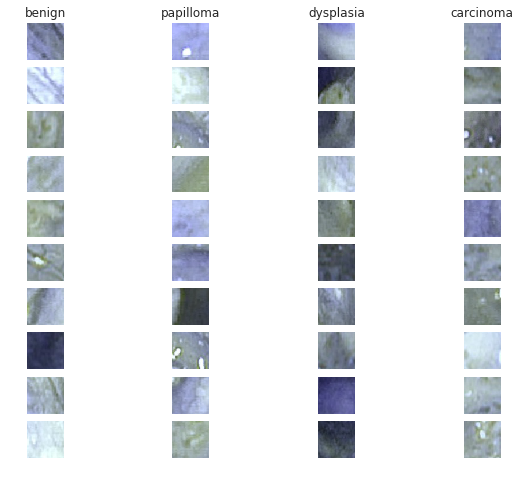

In [6]:
# benign, papilloma, dysplasia, carcinoma
classes = ['benign','papilloma','dysplasia','carcinoma']
n_classes = len(classes)
samples_per_class = 10

for y, cls in enumerate(classes):
    
    # convert boolean entries to index values
    class_instance_idxs = np.flatnonzero(train_labels == y)
    idxs = np.random.choice(class_instance_idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * n_classes + y + 1
        plt.subplot(samples_per_class, n_classes, plt_idx)
        plt.imshow(train_images[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## 1.2 Normalization

We scale the data down so the CNN can converge faster.

We also apply a simple mean subtraction.

see: [Data Preprocessing](http://ufldl.stanford.edu/wiki/index.php/Data_Preprocessing)

In [7]:
def simple_scale(data):
    # https://en.wikipedia.org/wiki/Feature_scaling
    return data / 255

#train_images = simple_scale(train_images)
#test_images = simple_scale(test_images)

def mean_subtraction(data):
    data -= np.mean(data)
    data /= np.std(data)
    return data
    
train_images = simple_scale(train_images)
test_images = simple_scale(test_images)

Now let's visualize one of our normalized images.

In [8]:
img = train_images[28]

fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.axis('off')
ax1.imshow(img[:,:,0])
ax2.imshow(img[:,:,1])
ax2.axis('off')
ax3.imshow(img[:,:,2])
ax3.axis('off')
plt.show()

# let's our scal
print(img[:3,:3,:])

[[[0.3764706  0.40784314 0.43529412]
  [0.3764706  0.40784314 0.43529412]
  [0.37254903 0.4117647  0.4392157 ]]

 [[0.3882353  0.41960785 0.44705883]
  [0.3764706  0.41568628 0.44313726]
  [0.36862746 0.40784314 0.43529412]]

 [[0.37254903 0.41568628 0.43137255]
  [0.3647059  0.40392157 0.43137255]
  [0.36862746 0.40784314 0.43529412]]]


### 1.3 Reshaping the Data

We don't need to reshape our data since it already is in the correct format for our model.

But we do need to convert our labels to one-hot encoding.

In [9]:
print(train_images.shape)
print(test_images.shape)

(9766, 64, 64, 3)
(2915, 64, 64, 3)


## 2 Convolutional Neural Network (CNN)

Now its time to build our model.

We're going to use the Keras Sequential API to add layers one at a time.

### 2.1 Defining the Model

In [47]:
model = Sequential()

# padding = 'same' ; this means we are zero padding the image
# kernel_size (5,5) ; this is automatically extended by keras to the depth of the image so the filter is really (5x5x3)

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
#model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # randomly kill some neurons to increase generalizability 


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
#model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))

In [48]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 64)        0         
__________

### 2.2 Setting the optimizer and annealer

Now that our layers are added to the model, we need to setup the following:

1. A loss function : we use `categorical_crossentropy` which is useful for classifications for $N_{classes} > 2$. 
2. A score function
3. An optimization algorithm : we use RMSprop

In [49]:
# Define the optimizer
learning_rate = 1e-3

optimizer = RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0)

In [23]:
# We want to evaluate our model on precision and recall so we need to define our own metrics
# see: https://en.wikipedia.org/wiki/Precision_and_recall
# original keras code: https://github.com/keras-team/keras/commit/a56b1a55182acf061b1eb2e2c86b48193a0e88f7


# That code doesn't work though, we'll have to figure something else out.

In [50]:
# Compile the model
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics=["accuracy"])

So the optimizer can converge faster and closest to the global minimum of the loss function, we use an annealing method of the learning rate (LR).

The `learning_rate (LR)` is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However, the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to efficiently reach the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, we'll decrease the LR dynamically every X steps (epochs) depending on whether or not it is necessary (it will be necessary when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, we'll choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [35]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [51]:
batch_size = 32

# increase the epochs to tune up the accuracy of the model
epochs = 10

## Performing Data Augmentation

by applying a couple of transformations to our dataset we can greatly increase the data in our dataset and improve the accuracy of our model. 

In [13]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range=10,                    # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                     # Randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,                 # randomly flip images
        vertical_flip=True)                   # randomly flip images


datagen.fit(train_images)

In [52]:
# Fit the model
#history = model.fit_generator(datagen.flow(train_images,train_labels_oh, batch_size=batch_size),
#                              epochs = epochs, validation_data = (test_images,test_labels_oh),
#                              verbose = 2, steps_per_epoch = train_images.shape[0] # batch_size
#                              , callbacks=[learning_rate_reduction])

history = model.fit(train_images,train_labels_oh, batch_size=batch_size,
                              epochs = epochs, validation_data = (test_images,test_labels_oh), shuffle=True,
                              verbose = 1, callbacks=[learning_rate_reduction])

Train on 9766 samples, validate on 2915 samples
Epoch 1/10
9766/9766 [==============================] - 320s 33ms/step - loss: 1.2301 - acc: 0.5284 - val_loss: 1.3910 - val_acc: 0.3832
Epoch 2/10
9766/9766 [==============================] - 316s 32ms/step - loss: 1.1111 - acc: 0.5756 - val_loss: 1.5003 - val_acc: 0.3719
Epoch 3/10
9766/9766 [==============================] - 319s 33ms/step - loss: 1.0690 - acc: 0.5863 - val_loss: 1.6490 - val_acc: 0.3698
Epoch 4/10
9766/9766 [==============================] - 308s 32ms/step - loss: 1.0419 - acc: 0.5927 - val_loss: 1.5280 - val_acc: 0.3643
Epoch 5/10
9766/9766 [==============================] - 313s 32ms/step - loss: 0.9870 - acc: 0.6025 - val_loss: 1.8636 - val_acc: 0.3722

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
9766/9766 [==============================] - 296s 30ms/step - loss: 0.8751 - acc: 0.6411 - val_loss: 1.5067 - val_acc: 0.3870
Epoch 7/10
9766/9766 [===========================

## 3. Evaluating the Model

### 3.1 Training and Validation Curves



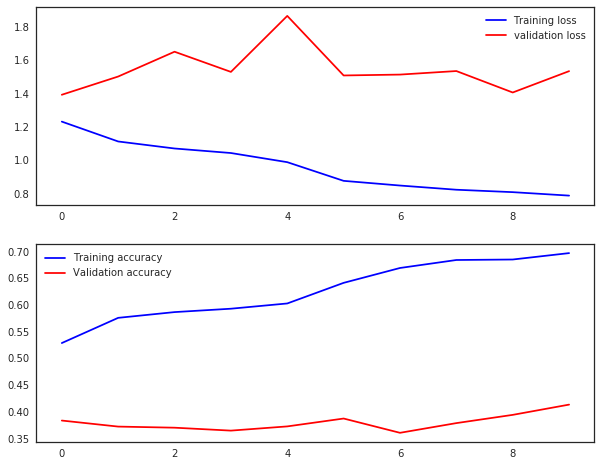

In [53]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 3.2 Confusion Matrix

We'll now inspect the confusion matrix to see if there are any drawbacks to our model.


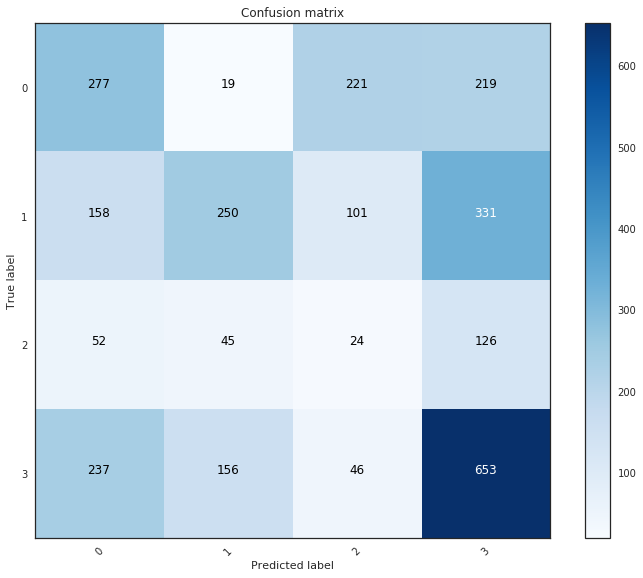

In [54]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(test_images)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Convert validation observations to one hot vectors
Y_true = np.argmax(test_labels_oh,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

In [55]:
from sklearn.metrics import recall_score, precision_score

recall = recall_score(Y_true, Y_pred_classes, average='macro')
precision = precision_score(Y_true, Y_pred_classes, average='macro')

print('recall: {}\nprecision: {}'.format(recall, precision))

recall: 0.34228227078985085
precision: 0.36677073646180114
